In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%%bash
# (70s)

mkdir ./modeling

echo "2*0.6 10*1 25*0.4 35*1.2 45*0.2" > ./modeling/timingsAM.1D

echo "2 10 25 35 45" > ./modeling/timings.1D

3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_AM1 1 ./modeling/timingsAM.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/data.1D


3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times 1 ./modeling/timings.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/clm_regressor.1D


3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_IM 1 ./modeling/timings.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/tlm_regressor.1D

mkdir: cannot create directory ‘./modeling’: File exists
++ '-stim_times_AM1 1 ./modeling/timingsAM.1D' has 1 auxiliary values per time point
++ GAM conversion: peak=3 fwhm=6 -> p=1.46087 q=2.05357
++ GAM conversion: peak=10 fwhm=12 -> p=3.92693 q=2.54652
++ waveform setup: TWOGAM()
*+ WARNING: no -stim_label given for stim #1 ==> label = 'Stim#1'
++ 3dDeconvolve: AFNI version=AFNI_20.1.00 (Apr  9 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.25 seconds for -stim_times and -nodata
++ using NT=48 time points for -nodata
++ -stim_times using TR=1.25 s for stimulus timing conversion
++ -stim_times using TR=1.25 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ ** -stim_times NOTE ** guessing GLOBAL times if 1 time per line; LOCAL otherwise
++ ** GUESSED ** -stim_times_AM1 1 using LOCAL times
++ '-stim_times_AM1 1' average amplitude#1=0.68
++ Number of time points: 48 (no censoring)
 + Number of parameters:  1 [0 baseline 

In [12]:
clm_reg = np.loadtxt('./modeling/clm_regressor.1D')
tlm_reg = np.loadtxt('./modeling/tlm_regressor.1D')
time=np.arange(len(clm_reg))*1.25

In [13]:
np.random.seed(42)
noise = np.random.normal(0,0.2,clm_reg.size)
raw = np.loadtxt('./modeling/data.1D') + noise

# 1. Condition Level Modeling vs. Trial Level Modeling.

Consider the following raw timeseries data which contains 7 events. 

The peaks for 7 events are not very evident due to random noise in the data.

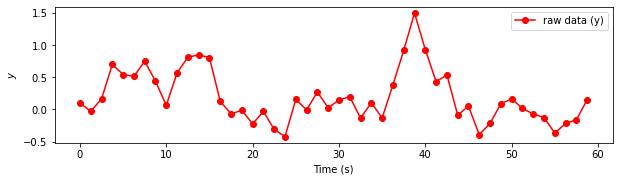

In [29]:
plt.figure(figsize=(10,2.5))
plt.plot(time,raw,color='red',label='raw data (y)',marker='o')
plt.xlabel('Time (s)')
plt.ylabel(r'$y$')
_=plt.legend()

## 1.1. Condition Level Modeling (CLM)

Conventional approach to model the responses is to specify a single regressor for a condition as follow:

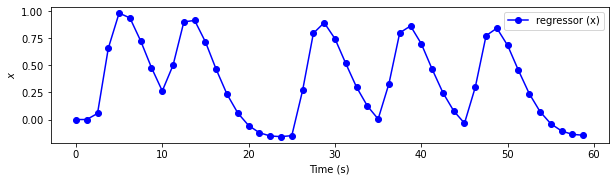

In [33]:
plt.figure(figsize=(10,2.5))
plt.plot(time,clm_reg,color='blue',label='regressor (x)',marker='o')
plt.xlabel('Time (s)')
plt.ylabel(r'$x$')
_=plt.legend()

Notice all peaks have approximately amplitude (1).

The raw data ($y$) can be regressed on $x$ by running a simple linear regression model.

$$\hat{y_{(i)}} = \beta_{0} + \beta_{x}x_{(i)}$$

Where $\hat{y_{(i)}}$ is estimated response for the $i$th timepoint.


In [31]:
lm_clm = LinearRegression()
X_clm = add_constant(clm_reg)
lm_clm.fit(X_clm,raw)
y_hat_clm = lm_clm.predict(X_clm)

Following shows the estimated response ($\hat{y}$) overlaid in the raw data ($y$).

Notice the amplitude of all peaks in $\hat{y}$ is the same, however now scaled down to 0.64 from 1 (because it happens to provide the best average fit).  

The 0.64 is the scaling factor ($\beta_{x}$) for the regressor $x$.


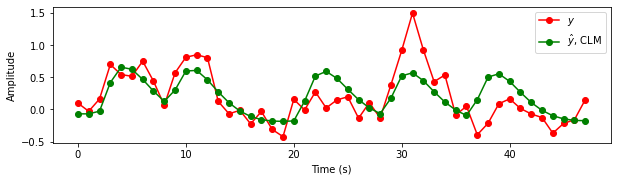

In [36]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$',marker='o')
plt.plot(y_hat_clm,color='green',label=r'$\hat{y}$, CLM',marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
_=plt.legend()

## 1.2. Trial level modeling (TLM)

In TLM every trail is modeled using a separate regressors even if the trials belong to the same condition. For example, as follow:

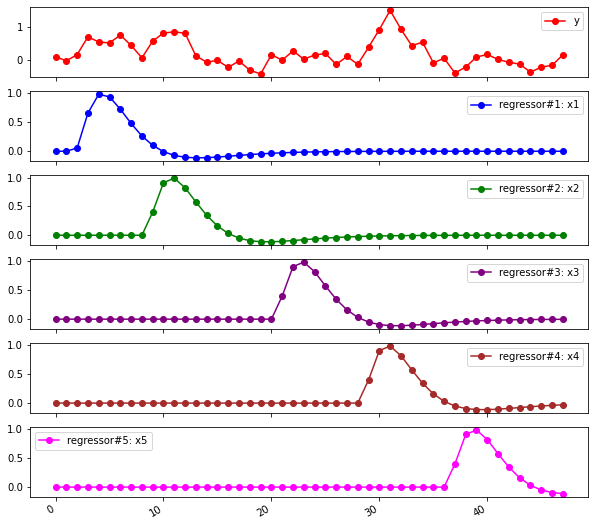

In [40]:
_=pd.DataFrame(np.hstack((raw[:,None],tlm_reg)),
               columns=['y']+['regressor#%i: x%i' %(i,i) for i in range(1,6)]).plot(subplots=True,
                                                                       color=['red','blue','green','purple','brown','magenta','cyan','black'],
                                                                       figsize=(10,10),marker='o')

Notice again, peaks of all 7 regressors have the same amplitude (1).

The raw data ($y$) can regressed on $x_{k}$ (where $k$ = 1,2,..n; n is total number of regressors) by running a multiple linear regression model.

$$\hat{y_{(i)}} = \beta_{0} + \sum^{n}_{k = 1}{\beta_{x_{k}}x_{k(i)}}$$

Where $\hat{y_{(i)}}$ is estimated response for $i$th timepoint.

In [39]:
lm_tlm = LinearRegression()
X_tlm = add_constant(tlm_reg)
lm_tlm.fit(X_tlm,raw)
y_hat_tlm = lm_tlm.predict(X_tlm)

Notice the peaks in $\hat{y}$ have acquired different amplitudes in order to approximate the raw data.  

That is, each regressor is now scaled by a different $\beta_{x_{k}}$, where k = 1,2,..,n.

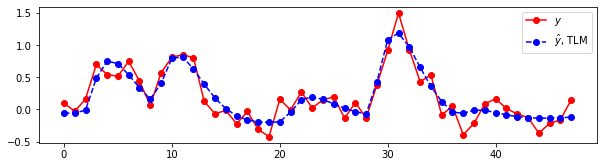

In [41]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$',marker='o')
plt.plot(y_hat_tlm,color='blue',label=r'$\hat{y}$, TLM',linestyle='--',marker='o')
#plt.legend(loc='upper left',bbox_to_anchor=[1,0.75])

_=plt.legend()

## 1.3. Visualizing both fits (CLM and TLM)

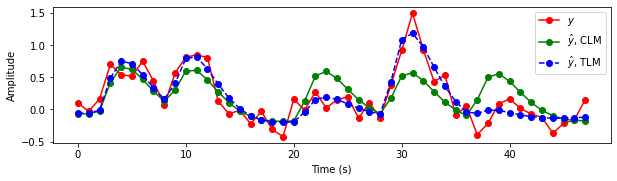

In [42]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$',marker='o')
plt.plot(y_hat_clm,color='green',label=r'$\hat{y}$, CLM',marker='o')
plt.plot(y_hat_tlm,color='blue',label=r'$\hat{y}$, TLM',linestyle='--',marker='o')
#plt.legend(loc='upper left',bbox_to_anchor=[1,0.75])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

From the plot itself it can be seen that TLM provides a better fit. 